<a href="https://colab.research.google.com/github/amir1m/learning-ml/blob/master/kernelkmeans_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kernalized KMeans implementation (WIP)
---



In [1]:
import numpy as np
np.random.seed(42)
from sklearn.datasets import make_blobs, make_circles
import pylab as plt
from sklearn import cluster, datasets, mixture
import random
random.seed(42)

from scipy.spatial import distance
from math import sqrt, exp
from sklearn.metrics import pairwise


## Dataset

In [2]:
#X, y = make_blobs(n_samples=500, centers=3, n_features=2, random_state=42)
#X, y = make_circles(factor=0.5, random_state=0, noise=0.05)
X= datasets.make_circles(n_samples=50, factor=.5,noise=.05)[0]
#Randomize some points
# n = int(X.shape[0] * 0.05) # 5 % 
# index = np.random.choice(X.shape[0], n, replace=False)  
# X[index] = X[index] + random.uniform(-10,10)

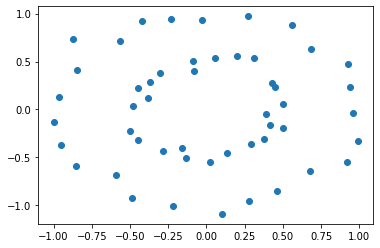

In [3]:
plt.scatter(X[:,0], X[:,1])

## K-Means

[[ 0.2737193  -1.03828097]
 [-0.45165143 -0.62957089]]


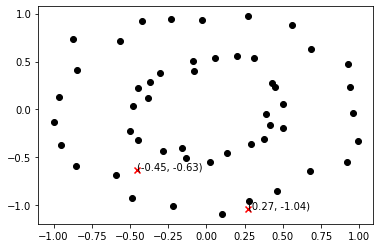

In [4]:
x1_min = np.min(X[:,0])
x1_max = np.max(X[:,0])

x2_min = np.min(X[:,1])
x2_max = np.max(X[:,1])

no_centroids = 2
znk = np.zeros((X.shape[0],no_centroids))
print

#Randomly initialize centroids
centroids = np.zeros((2,2))

centroids[0,0] = random.uniform(x1_min, x1_max)
centroids[0,1] = random.uniform(x2_min, x2_max)

centroids[1,0] = random.uniform(x1_min, x1_max)
centroids[1,1] = random.uniform(x2_min, x2_max)

initialised_centroids = centroids.copy()
print(centroids)

plt.scatter(centroids[:,0], centroids[:,1], marker='x', c='r')

plt.scatter(X[:,0], X[:,1], c='k')
for i_x, i_y in zip(centroids[:,0], centroids[:,1]):
    plt.text(i_x, i_y, '({}, {})'.format(round(i_x,2), round(i_y,2)))

In [5]:
znk = np.zeros((X.shape[0],no_centroids))
centroids = initialised_centroids.copy()

while True:
    old_znk = znk.copy()
    
    p=0
    for point in X:
        all_dist = []
        
        for center in centroids:
            #print("Point:", point, "Center:", center,"Distance=", distance.euclidean(point,center))
            eucldn_squared = distance.euclidean(point,center)**2
            dot_distance = np.dot((point - center).T, (point - center))
            all_dist.append(eucldn_squared)
            #print("Euclidean = ", eucldn_squared, " Dot distance = ", dot_distance)
        
        cluster = all_dist.index(min(all_dist))
        #print("all_dis: ", all_dist, " Cluster:", cluster)
        
        znk[p][0] = znk[p][1] = 0
        znk[p][cluster] = 1

        #print("ZNK : ", znk)
        
        p = p + 1 # Next point
    
    if (old_znk == znk).all():
        #print("OLD ZNK:", old_znk, " New ZNK: ", znk)
        break
        

    for j in range(len(centroids)):
        total_members = 0
        x1_sum = 0
        x2_sum = 0
        for i in range(len(X)):
            x1_sum = x1_sum + X[i][0]*znk[i, j]
            x2_sum = x2_sum + X[i][1]*znk[i, j]
            total_members = total_members + znk[i, j]
        #print("Total members:", total_members)
        if (total_members !=0):
            centroids[j] = [x1_sum/total_members, x2_sum/total_members]
            #print(centroids[j])    
    
    

In [6]:
print(centroids)
#np.dot((X - centroids[0]).T, (X - centroids[0]))


[[ 0.32917361 -0.33134621]
 [-0.35147945  0.35730701]]


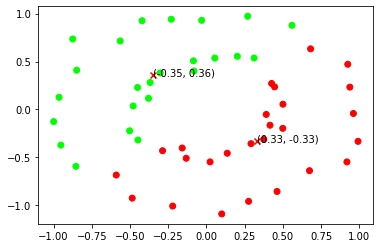

In [7]:
plt.scatter(centroids[:,0], centroids[:,1], marker='x', c='r')
h = np.zeros((X.shape[0], 1))
plt.scatter(X[:,0], X[:,1],c=np.hstack((znk,h)))


for i_x, i_y in zip(centroids[:,0], centroids[:,1]):
    plt.text(i_x, i_y, '({}, {})'.format(round(i_x,2), round(i_y,2)))

In [8]:
print(centroids)

[[ 0.32917361 -0.33134621]
 [-0.35147945  0.35730701]]


## Kernelised K-Means

In [9]:
def rbf_kernel(xn, xm, gamma = 0.1):
    return exp(-gamma * np.dot((xn - xm).T, (xn - xm)))

In [10]:
#znk = znk_kmean.copy()
print(X.shape[0])
znk = np.zeros((X.shape[0],2))
znk[:,0] = 1
znk[0,0] = 0
znk[0,1] = 1

50


In [11]:
%time
N = X.shape[0]
while True:
    #print("========================================")
    old_znk = znk.copy()
    first_term, second_term, third_term = 0,0,0
    p = 0
    for x in X:                                
        #first_term = pairwise.rbf_kernel(x.reshape(-1,1),x.reshape(-1,1))
        first_term = rbf_kernel(x,x)
        #first_term = pairwise.rbf_kernel(X,X)
        print("\n\nx=",x,"\nFirst Term:", first_term)
        all_dist = []
        for k in range(2):
            Nk = np.count_nonzero(znk[:,k])
            members = X[np.where(znk[:,k] == 1)]
            non_members = X[np.where(znk[:,k] == 0)]
            #print("Members:", members)
            
            if Nk != 0:
                result = 0
                for xm in members:
                    result = result + rbf_kernel(x,xm)

                second_term = (-2/Nk) * result
                print("Second Term:", second_term)

                result = 0
                for xm in members:
                    for xr in members:
                        result = result + rbf_kernel(xm,xr)

                third_term = (Nk**-2) * result
                print("Third Term:", third_term)
                
            dnk = first_term + second_term + third_term
            all_dist.append(dnk)
        
        cluster = all_dist.index(min(all_dist))
        #print("all_dis: ", all_dist, " Cluster:", cluster)
        
        znk[p][0] = 0
        znk[p][1] = 0
        znk[p][cluster] = 1
        p = p + 1

    if (old_znk == znk).all():
        #print("OLD ZNK:", old_znk, " New ZNK: ", znk)
        break
    #print("ZNK:\n",znk)



CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


x= [-0.99912563 -0.1269929 ] 
First Term: 1.0
Second Term: -1.7019002732830817
Third Term: 0.888278824368644
Second Term: -2.0
Third Term: 1.0


x= [-0.50234207 -0.22298138] 
First Term: 1.0
Second Term: -1.8242345545860206
Third Term: 0.888278824368644
Second Term: -1.9494483041659914
Third Term: 1.0


x= [0.20195064 0.55457079] 
First Term: 1.0
Second Term: -1.8237771708291781
Third Term: 0.8873133524888873
Second Term: -1.7221500958899028
Third Term: 0.9873620760414978


x= [ 0.13609995 -0.45675003] 
First Term: 1.0
Second Term: -1.8411637497040885
Third Term: 0.8873133524888873
Second Term: -1.824404143171695
Third Term: 0.9873620760414978


x= [-0.4854372  -0.92527965] 
First Term: 1.0
Second Term: -1.689287908122956
Third Term: 0.8873133524888873
Second Term: -1.8656743321553775
Third Term: 0.9873620760414978


x= [ 0.41581627 -0.16466476] 
First Term: 1.0
Second Term: -1.8522525756882555
Third Term: 0.889218716407

In [12]:
h = np.zeros((X.shape[0], 1))

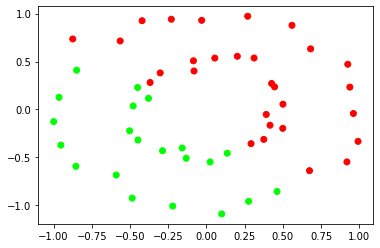

In [13]:
plt.scatter(X[:,0], X[:,1], c=np.hstack((znk,h)))